In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [3]:
d = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(d))
d.head()

544


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
hlp.pandas.numeric_summary(d)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
height,544,0,0.0%,0,0.0%,138.3,27.6,0.2,-1.3,0.6,54.0,91.4,125.1,148.6,157.5,162.6,179.1
weight,544,0,0.0%,0,0.0%,35.6,14.7,0.4,-0.5,-0.9,4.2,12.5,22.0,40.1,47.2,51.6,63.0
age,544,0,0.0%,11,2.0%,29.3,20.8,0.7,0.5,-0.5,0.0,3.0,12.0,27.0,43.0,58.0,88.0
male,544,0,0.0%,287,53.0%,0.5,0.5,1.1,0.1,-2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


---

# Model

In [6]:
d2 = d[d.age >= 18]

with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # mu = a + np.exp(b) * (d2.weight.values - xbar)
    # mu = a + np.exp(b) * (np.zeros(len(d2)) - d2.weight.mean())
    mu = a + np.exp(b) * (d2.weight.values - d2.weight.mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    # trace_4_3b = pm.sample(1000, tune=1000)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, b, height, sigma]


# Prior Checks

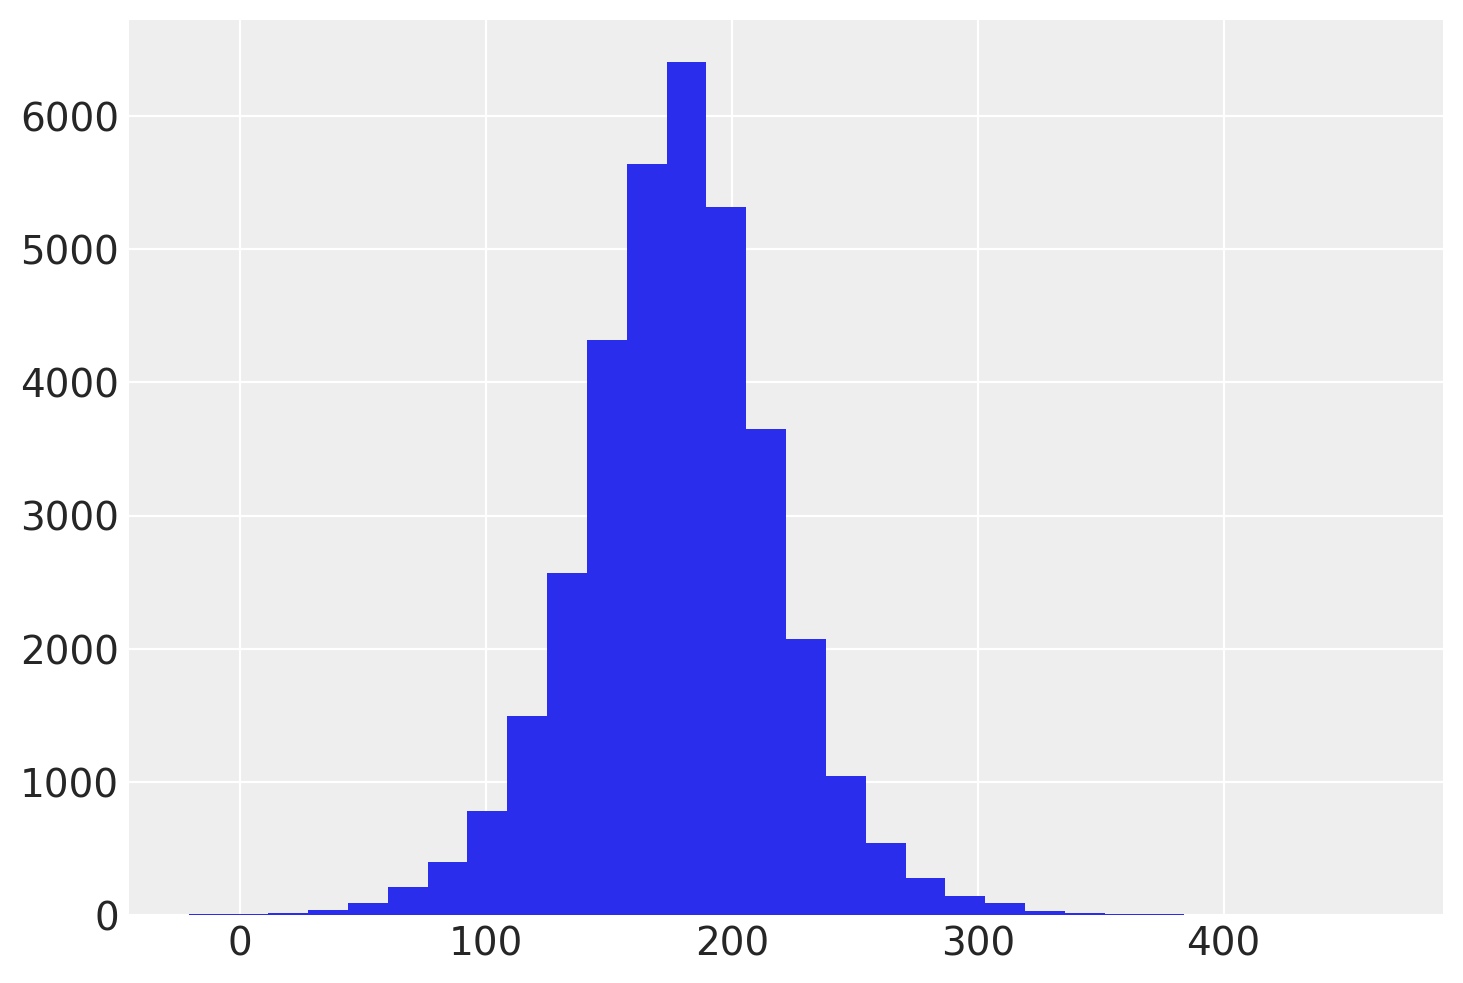

In [9]:
plt.hist(ph.get_prior_samples(idata_prior).flatten(), bins=30);

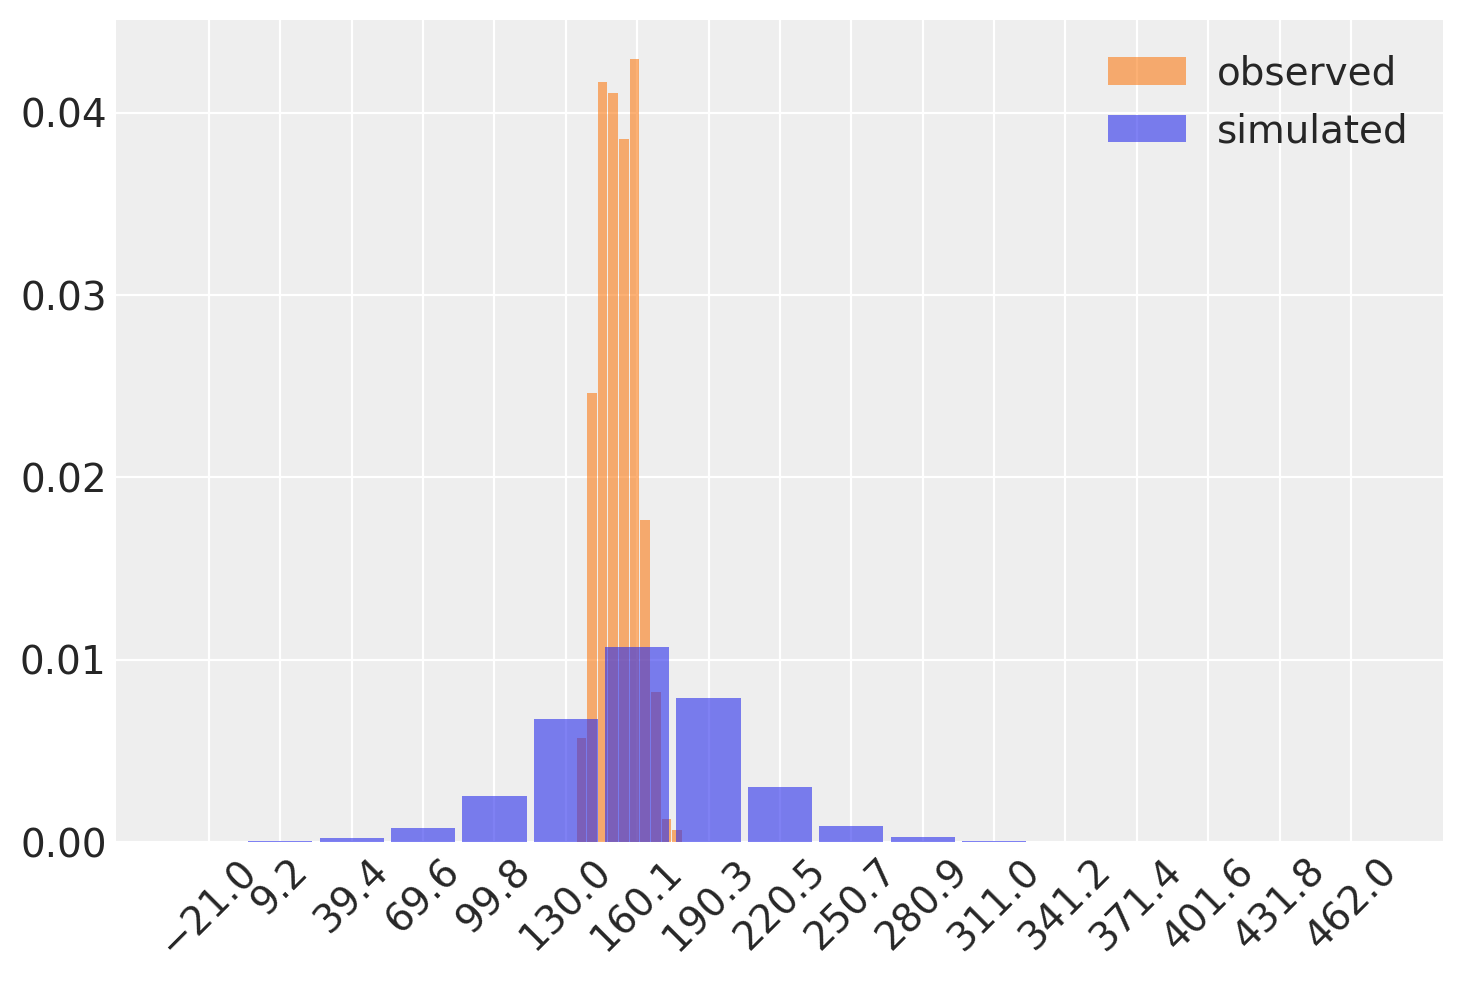

In [10]:
az.plot_dist(
    d2['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

In [ ]:
plt.hist(d2.height, bins=20)
plt.suptitle('Distribution of Height in Data');

In [ ]:
# for each value of weight in data, give simulations of height based on prior distributions
prior_samples = prior_checks.prior_predictive['height'].data[0]
prior_samples.shape

In [ ]:
plt.hist(np.median(prior_samples, axis=1), bins=30)
plt.suptitle('Distribution of Height in According to Priors');

In [ ]:
trace_4_3b

In [ ]:
with m4_3b:
    idata_posterior = pm.sample(draws=1000, tune=1000)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        #var_names=["a", "b", "obs"],
        random_seed=RANDOM_SEED
    )

In [ ]:
idata_posterior

In [ ]:
def get_dataset_names(inference_data: az.InferenceData) -> list[str]:
    return inference_data._group_names(None, None)

get_dataset_names(idata_posterior)

In [ ]:
def get_variable_names(inference_data: az.InferenceData) -> list[str]:
    return list(inference_data[get_dataset_names(inference_data)[0]].data_vars)

get_variable_names(idata_posterior)

In [ ]:
get_variable_names(idata_predictive)

In [ ]:
idata_posterior.posterior['a'].stack(sample=["chain", "draw"]).data.shape

In [ ]:
def get_posterior_samples(posterior_inference: az.InferenceData, variable_name: str):
    return posterior_inference.posterior[variable_name].stack(sample=["chain", "draw"]).data.shape

get_posterior_samples(idata_posterior, 'a')

In [ ]:
idata_predictive.posterior_predictive

In [ ]:
get_variable_names(idata_predictive)[0]

In [ ]:
def get_prediction_samples(prediction_inference: az.InferenceData):
    variable_name = get_variable_names(prediction_inference)[0]
    return prediction_inference.posterior_predictive[variable_name].stack(sample=["chain", "draw"]).data

get_prediction_samples(idata_predictive).shape

In [ ]:
posterior_predictive.posterior_predictive['height'].data.shape

In [ ]:
posterior_predictive.posterior_predictive.sel(chain=[0, 1, 2])['height'].data.shape

In [ ]:
posterior_predictive.posterior_predictive.stack(sample=["chain", "draw"])['height'].data.shape

In [ ]:
predictions = posterior_predictive.posterior_predictive.stack(sample=["chain", "draw"])
predictions

In [ ]:
az.convert_to_dataset(posterior_predictive.posterior_predictive['height'])

In [ ]:
idata.posterior.stack(draws=("chain", "draw"))

In [ ]:
with m4
ppc = pm.sample_posterior_predictive(
    trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED
    )

In [ ]:
az.summary(trace_4_3b, kind="stats")